In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as im
from sklearn.cluster import KMeans
import os
import imageio
from PIL import Image

%matplotlib inline


In [3]:
#Clothing part
foldername = "./fashion";
topcolors = 2 #the number of top colors we want to compare

#iterate through folder and find kmeans data

num_points = len(os.listdir(foldername))

centerPoints = np.zeros((num_points,topcolors,3))
weights = np.ones((topcolors,1))
count =0

for item in os.listdir(foldername):
 
    image = Image.open(foldername+'/'+item)
    
    x = 64
    y = 64
    z = 3
    
    resized_image = image.resize((x,y))

    
    newim = np.reshape(resized_image,(x*y,z))

    
    kmeans = KMeans(n_clusters=topcolors, random_state=0).fit(newim)
    centers = kmeans.cluster_centers_  #cluster centers
    cluster_ids = kmeans.labels_
    for i in range(0,topcolors):
        vec = (cluster_ids == i)
        num = np.sum(vec)
        weights[i] = num/(x*y)
        
    order = np.argsort(weights,axis = None)
        
    centerPoints[count,:,:]=centers[order] #the top colors in the picture
    
    
    
    
    
    
    count = count +1;
    



In [4]:
def Euclid_dist(x, y):

    ndim = x.shape[0];

    dist= np.sqrt(np.sum(np.square(x-y)))

        
    return dist
    raise NotImplementedError
    



def distanceCalc(centerPoints):
    #centePoints is num*col*3
    num = centerPoints.shape[0]
    col = centerPoints.shape[1]
    FirstIm = np.zeros((3,1));
    SecondIm = np.zeros((3,1));
    distvec = np.zeros((num,num))
    dist = 0
    
    for i in range(0,num):
        for j in range(0,num):
            for k in range(0,col):
                FirstIm[0] = centerPoints[i,k,0];
                FirstIm[1] = centerPoints[i,k,1];
                FirstIm[2] = centerPoints[i,k,2];
                
                SecondIm[0] = centerPoints[j,k,0]
                SecondIm[1] = centerPoints[j,k,1]
                SecondIm[2] = centerPoints[j,k,2]
                
                dist = dist + Euclid_dist(FirstIm,SecondIm)
                
                
            distvec[i,j] = dist
            distvec[j,i] = dist
            dist = 0
            
            
            
    return distvec




def findGroup(WantedDist,distances):
    indices = np.argwhere(distances <= WantedDist)
    num = indices.shape[0]
    count = 0;
    
    
    for i in range(0,num):
       
        for j in range(0,num):
            if (indices[j,0] == i):
                if (count == 0):
                    newvec = indices[j,1]
                else:
                    newvec = np.append(newvec,indices[j,1])
                count = count+1
        count = 0;
        
        if(i == 0):
            store = newvec
        else:
            store = np.append(store,newvec)
            
        store = np.append(store,-1)
        
        
    return store
        
      
    
    
                
                
                
                

In [ ]:
#This is just a test
# Still working output
distances = distanceCalc(centerPoints)


picNums = os.listdir(foldername)


for i in range(0,7):
    print("Level:"+str(i))
    store =findGroup(i*50,distances)
    
    indices = np.where(store == -1)
    count = 0
    #print(indices)
    
    for j in range(0,len(store)):
        if(store[j] ==-1):
            count = count+1
        else:
            print("Cluster: "+ str(count))
        
            image = im.imread("./fashion/" + str(picNums[store[j]]))
            print("./fashion/"+picNums[store[j]])
            plt.imshow(image)
    
    
        

Level:0
Cluster: 0
./fashion/8.jpg
Cluster: 1
./fashion/9.jpg
Cluster: 2
./fashion/14.jpg
Cluster: 3
./fashion/28.jpg
Cluster: 4
./fashion/29.jpg
Cluster: 5
./fashion/15.jpg
Cluster: 6
./fashion/17.jpg
Cluster: 7
./fashion/16.jpg
Cluster: 8
./fashion/12.jpg
Cluster: 9
./fashion/13.jpg
Cluster: 10
./fashion/11.jpg
Cluster: 11
./fashion/10.jpg
Cluster: 12
./fashion/21.jpg
Cluster: 13
./fashion/20.jpg
Cluster: 14
./fashion/22.jpg
Cluster: 15
./fashion/23.jpg
Cluster: 16
./fashion/26.jpg
Cluster: 17
./fashion/18.jpg
Cluster: 18
./fashion/24.jpg
Cluster: 19
./fashion/30.jpg
Cluster: 20
./fashion/31.jpg
Cluster: 21
./fashion/25.jpg
Cluster: 22
./fashion/19.jpg
Cluster: 23
./fashion/4.jpg
Cluster: 24
./fashion/5.jpg
Cluster: 25
./fashion/6.jpg
Cluster: 26
./fashion/2.jpg
Cluster: 27
./fashion/3.jpg
Cluster: 28
./fashion/1.jpg
Level:1
Cluster: 0
./fashion/8.jpg
Cluster: 1
./fashion/9.jpg
Cluster: 2
./fashion/14.jpg
Cluster: 3
./fashion/28.jpg
Cluster: 4
./fashion/29.jpg
Cluster: 5
./fashion/15

./fashion/10.jpg
Cluster: 1
./fashion/20.jpg
Cluster: 1
./fashion/30.jpg
Cluster: 1
./fashion/31.jpg
Cluster: 1
./fashion/6.jpg
Cluster: 2
./fashion/8.jpg
Cluster: 2
./fashion/14.jpg
Cluster: 2
./fashion/17.jpg
Cluster: 2
./fashion/11.jpg
Cluster: 2
./fashion/23.jpg
Cluster: 2
./fashion/26.jpg
Cluster: 2
./fashion/5.jpg
Cluster: 2
./fashion/2.jpg
Cluster: 3
./fashion/28.jpg
Cluster: 3
./fashion/17.jpg
Cluster: 3
./fashion/22.jpg
Cluster: 3
./fashion/23.jpg
Cluster: 3
./fashion/2.jpg
Cluster: 4
./fashion/29.jpg
Cluster: 4
./fashion/16.jpg
Cluster: 4
./fashion/25.jpg
Cluster: 4
./fashion/3.jpg
Cluster: 5
./fashion/15.jpg
Cluster: 5
./fashion/16.jpg
Cluster: 5
./fashion/18.jpg
Cluster: 5
./fashion/24.jpg
Cluster: 5
./fashion/25.jpg
Cluster: 5
./fashion/19.jpg
Cluster: 5
./fashion/4.jpg
Cluster: 5
./fashion/3.jpg
Cluster: 6
./fashion/14.jpg
Cluster: 6
./fashion/28.jpg
Cluster: 6
./fashion/17.jpg
Cluster: 6
./fashion/11.jpg
Cluster: 6
./fashion/22.jpg
Cluster: 6
./fashion/23.jpg
Cluster: 6


Cluster: 60
./fashion/4.jpg
Cluster: 60
./fashion/1.jpg
Cluster: 61
./fashion/12.jpg
Cluster: 61
./fashion/18.jpg
Cluster: 61
./fashion/4.jpg
Cluster: 61
./fashion/1.jpg
Cluster: 62
./fashion/12.jpg
Cluster: 62
./fashion/18.jpg
Cluster: 62
./fashion/4.jpg
Cluster: 62
./fashion/1.jpg
Cluster: 63
./fashion/12.jpg
Cluster: 63
./fashion/18.jpg
Cluster: 63
./fashion/4.jpg
Cluster: 63
./fashion/1.jpg
Cluster: 64
./fashion/12.jpg
Cluster: 64
./fashion/18.jpg
Cluster: 64
./fashion/4.jpg
Cluster: 64
./fashion/1.jpg
Cluster: 65
./fashion/12.jpg
Cluster: 65
./fashion/18.jpg
Cluster: 65
./fashion/4.jpg
Cluster: 65
./fashion/1.jpg
Cluster: 66
./fashion/12.jpg
Cluster: 66
./fashion/18.jpg
Cluster: 66
./fashion/4.jpg
Cluster: 66
./fashion/1.jpg
Cluster: 67
./fashion/12.jpg
Cluster: 67
./fashion/18.jpg
Cluster: 67
./fashion/4.jpg
Cluster: 67
./fashion/1.jpg
Cluster: 68
./fashion/12.jpg
Cluster: 68
./fashion/18.jpg
Cluster: 68
./fashion/4.jpg
Cluster: 68
./fashion/1.jpg
Cluster: 69
./fashion/12.jpg
Clu

Cluster: 134
./fashion/12.jpg
Cluster: 134
./fashion/18.jpg
Cluster: 134
./fashion/4.jpg
Cluster: 134
./fashion/1.jpg
Cluster: 135
./fashion/12.jpg
Cluster: 135
./fashion/18.jpg
Cluster: 135
./fashion/4.jpg
Cluster: 135
./fashion/1.jpg
Cluster: 136
./fashion/12.jpg
Cluster: 136
./fashion/18.jpg
Cluster: 136
./fashion/4.jpg
Cluster: 136
./fashion/1.jpg
Cluster: 137
./fashion/12.jpg
Cluster: 137
./fashion/18.jpg
Cluster: 137
./fashion/4.jpg
Cluster: 137
./fashion/1.jpg
Cluster: 138
./fashion/12.jpg
Cluster: 138
./fashion/18.jpg
Cluster: 138
./fashion/4.jpg
Cluster: 138
./fashion/1.jpg
Cluster: 139
./fashion/12.jpg
Cluster: 139
./fashion/18.jpg
Cluster: 139
./fashion/4.jpg
Cluster: 139
./fashion/1.jpg
Cluster: 140
./fashion/12.jpg
Cluster: 140
./fashion/18.jpg
Cluster: 140
./fashion/4.jpg
Cluster: 140
./fashion/1.jpg
Cluster: 141
./fashion/12.jpg
Cluster: 141
./fashion/18.jpg
Cluster: 141
./fashion/4.jpg
Cluster: 141
./fashion/1.jpg
Cluster: 142
./fashion/12.jpg
Cluster: 142
./fashion/18.

Cluster: 10
./fashion/20.jpg
Cluster: 10
./fashion/22.jpg
Cluster: 10
./fashion/23.jpg
Cluster: 10
./fashion/26.jpg
Cluster: 10
./fashion/30.jpg
Cluster: 10
./fashion/31.jpg
Cluster: 10
./fashion/6.jpg
Cluster: 10
./fashion/2.jpg
Cluster: 11
./fashion/9.jpg
Cluster: 11
./fashion/11.jpg
Cluster: 11
./fashion/10.jpg
Cluster: 11
./fashion/20.jpg
Cluster: 11
./fashion/30.jpg
Cluster: 11
./fashion/31.jpg
Cluster: 11
./fashion/6.jpg
Cluster: 11
./fashion/2.jpg
Cluster: 12
./fashion/28.jpg
Cluster: 12
./fashion/21.jpg
Cluster: 12
./fashion/23.jpg
Cluster: 12
./fashion/26.jpg
Cluster: 12
./fashion/5.jpg
Cluster: 13
./fashion/9.jpg
Cluster: 13
./fashion/17.jpg
Cluster: 13
./fashion/11.jpg
Cluster: 13
./fashion/10.jpg
Cluster: 13
./fashion/20.jpg
Cluster: 13
./fashion/22.jpg
Cluster: 13
./fashion/31.jpg
Cluster: 13
./fashion/2.jpg
Cluster: 14
./fashion/14.jpg
Cluster: 14
./fashion/28.jpg
Cluster: 14
./fashion/17.jpg
Cluster: 14
./fashion/11.jpg
Cluster: 14
./fashion/20.jpg
Cluster: 14
./fashion/

Cluster: 39
./fashion/18.jpg
Cluster: 39
./fashion/24.jpg
Cluster: 39
./fashion/25.jpg
Cluster: 39
./fashion/19.jpg
Cluster: 39
./fashion/4.jpg
Cluster: 39
./fashion/3.jpg
Cluster: 39
./fashion/1.jpg
Cluster: 40
./fashion/15.jpg
Cluster: 40
./fashion/16.jpg
Cluster: 40
./fashion/12.jpg
Cluster: 40
./fashion/13.jpg
Cluster: 40
./fashion/18.jpg
Cluster: 40
./fashion/24.jpg
Cluster: 40
./fashion/25.jpg
Cluster: 40
./fashion/19.jpg
Cluster: 40
./fashion/4.jpg
Cluster: 40
./fashion/3.jpg
Cluster: 40
./fashion/1.jpg
Cluster: 41
./fashion/15.jpg
Cluster: 41
./fashion/16.jpg
Cluster: 41
./fashion/12.jpg
Cluster: 41
./fashion/13.jpg
Cluster: 41
./fashion/18.jpg
Cluster: 41
./fashion/24.jpg
Cluster: 41
./fashion/25.jpg
Cluster: 41
./fashion/19.jpg
Cluster: 41
./fashion/4.jpg
Cluster: 41
./fashion/3.jpg
Cluster: 41
./fashion/1.jpg
Cluster: 42
./fashion/15.jpg
Cluster: 42
./fashion/16.jpg
Cluster: 42
./fashion/12.jpg
Cluster: 42
./fashion/13.jpg
Cluster: 42
./fashion/18.jpg
Cluster: 42
./fashion/2

./fashion/15.jpg
Cluster: 66
./fashion/16.jpg
Cluster: 66
./fashion/12.jpg
Cluster: 66
./fashion/13.jpg
Cluster: 66
./fashion/18.jpg
Cluster: 66
./fashion/24.jpg
Cluster: 66
./fashion/25.jpg
Cluster: 66
./fashion/19.jpg
Cluster: 66
./fashion/4.jpg
Cluster: 66
./fashion/3.jpg
Cluster: 66
./fashion/1.jpg
Cluster: 67
./fashion/15.jpg
Cluster: 67
./fashion/16.jpg
Cluster: 67
./fashion/12.jpg
Cluster: 67
./fashion/13.jpg
Cluster: 67
./fashion/18.jpg
Cluster: 67
./fashion/24.jpg
Cluster: 67
./fashion/25.jpg
Cluster: 67
./fashion/19.jpg
Cluster: 67
./fashion/4.jpg
Cluster: 67
./fashion/3.jpg
Cluster: 67
./fashion/1.jpg
Cluster: 68
./fashion/15.jpg
Cluster: 68
./fashion/16.jpg
Cluster: 68
./fashion/12.jpg
Cluster: 68
./fashion/13.jpg
Cluster: 68
./fashion/18.jpg
Cluster: 68
./fashion/24.jpg
Cluster: 68
./fashion/25.jpg
Cluster: 68
./fashion/19.jpg
Cluster: 68
./fashion/4.jpg
Cluster: 68
./fashion/3.jpg
Cluster: 68
./fashion/1.jpg
Cluster: 69
./fashion/15.jpg
Cluster: 69
./fashion/16.jpg
Cluste

./fashion/25.jpg
Cluster: 93
./fashion/19.jpg
Cluster: 93
./fashion/4.jpg
Cluster: 93
./fashion/3.jpg
Cluster: 93
./fashion/1.jpg
Cluster: 94
./fashion/15.jpg
Cluster: 94
./fashion/16.jpg
Cluster: 94
./fashion/12.jpg
Cluster: 94
./fashion/13.jpg
Cluster: 94
./fashion/18.jpg
Cluster: 94
./fashion/24.jpg
Cluster: 94
./fashion/25.jpg
Cluster: 94
./fashion/19.jpg
Cluster: 94
./fashion/4.jpg
Cluster: 94
./fashion/3.jpg
Cluster: 94
./fashion/1.jpg
Cluster: 95
./fashion/15.jpg
Cluster: 95
./fashion/16.jpg
Cluster: 95
./fashion/12.jpg
Cluster: 95
./fashion/13.jpg
Cluster: 95
./fashion/18.jpg
Cluster: 95
./fashion/24.jpg
Cluster: 95
./fashion/25.jpg
Cluster: 95
./fashion/19.jpg
Cluster: 95
./fashion/4.jpg
Cluster: 95
./fashion/3.jpg
Cluster: 95
./fashion/1.jpg
Cluster: 96
./fashion/15.jpg
Cluster: 96
./fashion/16.jpg
Cluster: 96
./fashion/12.jpg
Cluster: 96
./fashion/13.jpg
Cluster: 96
./fashion/18.jpg
Cluster: 96
./fashion/24.jpg
Cluster: 96
./fashion/25.jpg
Cluster: 96
./fashion/19.jpg
Cluste

Cluster: 120
./fashion/16.jpg
Cluster: 120
./fashion/12.jpg
Cluster: 120
./fashion/13.jpg
Cluster: 120
./fashion/18.jpg
Cluster: 120
./fashion/24.jpg
Cluster: 120
./fashion/25.jpg
Cluster: 120
./fashion/19.jpg
Cluster: 120
./fashion/4.jpg
Cluster: 120
./fashion/3.jpg
Cluster: 120
./fashion/1.jpg
Cluster: 121
./fashion/15.jpg
Cluster: 121
./fashion/16.jpg
Cluster: 121
./fashion/12.jpg
Cluster: 121
./fashion/13.jpg
Cluster: 121
./fashion/18.jpg
Cluster: 121
./fashion/24.jpg
Cluster: 121
./fashion/25.jpg
Cluster: 121
./fashion/19.jpg
Cluster: 121
./fashion/4.jpg
Cluster: 121
./fashion/3.jpg
Cluster: 121
./fashion/1.jpg
Cluster: 122
./fashion/15.jpg
Cluster: 122
./fashion/16.jpg
Cluster: 122
./fashion/12.jpg
Cluster: 122
./fashion/13.jpg
Cluster: 122
./fashion/18.jpg
Cluster: 122
./fashion/24.jpg
Cluster: 122
./fashion/25.jpg
Cluster: 122
./fashion/19.jpg
Cluster: 122
./fashion/4.jpg
Cluster: 122
./fashion/3.jpg
Cluster: 122
./fashion/1.jpg
Cluster: 123
./fashion/15.jpg
Cluster: 123
./fash

Cluster: 146
./fashion/13.jpg
Cluster: 146
./fashion/18.jpg
Cluster: 146
./fashion/24.jpg
Cluster: 146
./fashion/25.jpg
Cluster: 146
./fashion/19.jpg
Cluster: 146
./fashion/4.jpg
Cluster: 146
./fashion/3.jpg
Cluster: 146
./fashion/1.jpg
Cluster: 147
./fashion/15.jpg
Cluster: 147
./fashion/16.jpg
Cluster: 147
./fashion/12.jpg
Cluster: 147
./fashion/13.jpg
Cluster: 147
./fashion/18.jpg
Cluster: 147
./fashion/24.jpg
Cluster: 147
./fashion/25.jpg
Cluster: 147
./fashion/19.jpg
Cluster: 147
./fashion/4.jpg
Cluster: 147
./fashion/3.jpg
Cluster: 147
./fashion/1.jpg
Cluster: 148
./fashion/15.jpg
Cluster: 148
./fashion/16.jpg
Cluster: 148
./fashion/12.jpg
Cluster: 148
./fashion/13.jpg
Cluster: 148
./fashion/18.jpg
Cluster: 148
./fashion/24.jpg
Cluster: 148
./fashion/25.jpg
Cluster: 148
./fashion/19.jpg
Cluster: 148
./fashion/4.jpg
Cluster: 148
./fashion/3.jpg
Cluster: 148
./fashion/1.jpg
Cluster: 149
./fashion/15.jpg
Cluster: 149
./fashion/16.jpg
Cluster: 149
./fashion/12.jpg
Cluster: 149
./fash

Cluster: 172
./fashion/18.jpg
Cluster: 172
./fashion/24.jpg
Cluster: 172
./fashion/25.jpg
Cluster: 172
./fashion/19.jpg
Cluster: 172
./fashion/4.jpg
Cluster: 172
./fashion/3.jpg
Cluster: 172
./fashion/1.jpg
Cluster: 173
./fashion/15.jpg
Cluster: 173
./fashion/16.jpg
Cluster: 173
./fashion/12.jpg
Cluster: 173
./fashion/13.jpg
Cluster: 173
./fashion/18.jpg
Cluster: 173
./fashion/24.jpg
Cluster: 173
./fashion/25.jpg
Cluster: 173
./fashion/19.jpg
Cluster: 173
./fashion/4.jpg
Cluster: 173
./fashion/3.jpg
Cluster: 173
./fashion/1.jpg
Cluster: 174
./fashion/15.jpg
Cluster: 174
./fashion/16.jpg
Cluster: 174
./fashion/12.jpg
Cluster: 174
./fashion/13.jpg
Cluster: 174
./fashion/18.jpg
Cluster: 174
./fashion/24.jpg
Cluster: 174
./fashion/25.jpg
Cluster: 174
./fashion/19.jpg
Cluster: 174
./fashion/4.jpg
Cluster: 174
./fashion/3.jpg
Cluster: 174
./fashion/1.jpg
Cluster: 175
./fashion/15.jpg
Cluster: 175
./fashion/16.jpg
Cluster: 175
./fashion/12.jpg
Cluster: 175
./fashion/13.jpg
Cluster: 175
./fash

Cluster: 197
./fashion/1.jpg
Cluster: 198
./fashion/15.jpg
Cluster: 198
./fashion/16.jpg
Cluster: 198
./fashion/12.jpg
Cluster: 198
./fashion/13.jpg
Cluster: 198
./fashion/18.jpg
Cluster: 198
./fashion/24.jpg
Cluster: 198
./fashion/25.jpg
Cluster: 198
./fashion/19.jpg
Cluster: 198
./fashion/4.jpg
Cluster: 198
./fashion/3.jpg
Cluster: 198
./fashion/1.jpg
Cluster: 199
./fashion/15.jpg
Cluster: 199
./fashion/16.jpg
Cluster: 199
./fashion/12.jpg
Cluster: 199
./fashion/13.jpg
Cluster: 199
./fashion/18.jpg
Cluster: 199
./fashion/24.jpg
Cluster: 199
./fashion/25.jpg
Cluster: 199
./fashion/19.jpg
Cluster: 199
./fashion/4.jpg
Cluster: 199
./fashion/3.jpg
Cluster: 199
./fashion/1.jpg
Cluster: 200
./fashion/15.jpg
Cluster: 200
./fashion/16.jpg
Cluster: 200
./fashion/12.jpg
Cluster: 200
./fashion/13.jpg
Cluster: 200
./fashion/18.jpg
Cluster: 200
./fashion/24.jpg
Cluster: 200
./fashion/25.jpg
Cluster: 200
./fashion/19.jpg
Cluster: 200
./fashion/4.jpg
Cluster: 200
./fashion/3.jpg
Cluster: 200
./fash

Cluster: 223
./fashion/18.jpg
Cluster: 223
./fashion/24.jpg
Cluster: 223
./fashion/25.jpg
Cluster: 223
./fashion/19.jpg
Cluster: 223
./fashion/4.jpg
Cluster: 223
./fashion/3.jpg
Cluster: 223
./fashion/1.jpg
Cluster: 224
./fashion/15.jpg
Cluster: 224
./fashion/16.jpg
Cluster: 224
./fashion/12.jpg
Cluster: 224
./fashion/13.jpg
Cluster: 224
./fashion/18.jpg
Cluster: 224
./fashion/24.jpg
Cluster: 224
./fashion/25.jpg
Cluster: 224
./fashion/19.jpg
Cluster: 224
./fashion/4.jpg
Cluster: 224
./fashion/3.jpg
Cluster: 224
./fashion/1.jpg
Cluster: 225
./fashion/15.jpg
Cluster: 225
./fashion/16.jpg
Cluster: 225
./fashion/12.jpg
Cluster: 225
./fashion/13.jpg
Cluster: 225
./fashion/18.jpg
Cluster: 225
./fashion/24.jpg
Cluster: 225
./fashion/25.jpg
Cluster: 225
./fashion/19.jpg
Cluster: 225
./fashion/4.jpg
Cluster: 225
./fashion/3.jpg
Cluster: 225
./fashion/1.jpg
Cluster: 226
./fashion/15.jpg
Cluster: 226
./fashion/16.jpg
Cluster: 226
./fashion/12.jpg
Cluster: 226
./fashion/13.jpg
Cluster: 226
./fash

Cluster: 250
./fashion/24.jpg
Cluster: 250
./fashion/25.jpg
Cluster: 250
./fashion/19.jpg
Cluster: 250
./fashion/4.jpg
Cluster: 250
./fashion/3.jpg
Cluster: 250
./fashion/1.jpg
Cluster: 251
./fashion/15.jpg
Cluster: 251
./fashion/16.jpg
Cluster: 251
./fashion/12.jpg
Cluster: 251
./fashion/13.jpg
Cluster: 251
./fashion/18.jpg
Cluster: 251
./fashion/24.jpg
Cluster: 251
./fashion/25.jpg
Cluster: 251
./fashion/19.jpg
Cluster: 251
./fashion/4.jpg
Cluster: 251
./fashion/3.jpg
Cluster: 251
./fashion/1.jpg
Cluster: 252
./fashion/15.jpg
Cluster: 252
./fashion/16.jpg
Cluster: 252
./fashion/12.jpg
Cluster: 252
./fashion/13.jpg
Cluster: 252
./fashion/18.jpg
Cluster: 252
./fashion/24.jpg
Cluster: 252
./fashion/25.jpg
Cluster: 252
./fashion/19.jpg
Cluster: 252
./fashion/4.jpg
Cluster: 252
./fashion/3.jpg
Cluster: 252
./fashion/1.jpg
Cluster: 253
./fashion/15.jpg
Cluster: 253
./fashion/16.jpg
Cluster: 253
./fashion/12.jpg
Cluster: 253
./fashion/13.jpg
Cluster: 253
./fashion/18.jpg
Cluster: 253
./fash

Cluster: 4
./fashion/1.jpg
Cluster: 5
./fashion/29.jpg
Cluster: 5
./fashion/15.jpg
Cluster: 5
./fashion/16.jpg
Cluster: 5
./fashion/12.jpg
Cluster: 5
./fashion/13.jpg
Cluster: 5
./fashion/18.jpg
Cluster: 5
./fashion/24.jpg
Cluster: 5
./fashion/25.jpg
Cluster: 5
./fashion/19.jpg
Cluster: 5
./fashion/4.jpg
Cluster: 5
./fashion/3.jpg
Cluster: 5
./fashion/1.jpg
Cluster: 6
./fashion/8.jpg
Cluster: 6
./fashion/9.jpg
Cluster: 6
./fashion/14.jpg
Cluster: 6
./fashion/28.jpg
Cluster: 6
./fashion/17.jpg
Cluster: 6
./fashion/11.jpg
Cluster: 6
./fashion/10.jpg
Cluster: 6
./fashion/21.jpg
Cluster: 6
./fashion/20.jpg
Cluster: 6
./fashion/22.jpg
Cluster: 6
./fashion/23.jpg
Cluster: 6
./fashion/26.jpg
Cluster: 6
./fashion/30.jpg
Cluster: 6
./fashion/5.jpg
Cluster: 6
./fashion/6.jpg
Cluster: 6
./fashion/2.jpg
Cluster: 7
./fashion/29.jpg
Cluster: 7
./fashion/15.jpg
Cluster: 7
./fashion/16.jpg
Cluster: 7
./fashion/12.jpg
Cluster: 7
./fashion/13.jpg
Cluster: 7
./fashion/18.jpg
Cluster: 7
./fashion/24.jpg
C

Cluster: 28
./fashion/4.jpg
Cluster: 28
./fashion/3.jpg
Cluster: 28
./fashion/1.jpg
Cluster: 29
./fashion/29.jpg
Cluster: 29
./fashion/15.jpg
Cluster: 29
./fashion/16.jpg
Cluster: 29
./fashion/12.jpg
Cluster: 29
./fashion/13.jpg
Cluster: 29
./fashion/18.jpg
Cluster: 29
./fashion/24.jpg
Cluster: 29
./fashion/25.jpg
Cluster: 29
./fashion/19.jpg
Cluster: 29
./fashion/4.jpg
Cluster: 29
./fashion/3.jpg
Cluster: 29
./fashion/1.jpg
Cluster: 30
./fashion/29.jpg
Cluster: 30
./fashion/15.jpg
Cluster: 30
./fashion/16.jpg
Cluster: 30
./fashion/12.jpg
Cluster: 30
./fashion/13.jpg
Cluster: 30
./fashion/18.jpg
Cluster: 30
./fashion/24.jpg
Cluster: 30
./fashion/25.jpg
Cluster: 30
./fashion/19.jpg
Cluster: 30
./fashion/4.jpg
Cluster: 30
./fashion/3.jpg
Cluster: 30
./fashion/1.jpg
Cluster: 31
./fashion/29.jpg
Cluster: 31
./fashion/15.jpg
Cluster: 31
./fashion/16.jpg
Cluster: 31
./fashion/12.jpg
Cluster: 31
./fashion/13.jpg
Cluster: 31
./fashion/18.jpg
Cluster: 31
./fashion/24.jpg
Cluster: 31
./fashion/2

./fashion/1.jpg
Cluster: 54
./fashion/29.jpg
Cluster: 54
./fashion/15.jpg
Cluster: 54
./fashion/16.jpg
Cluster: 54
./fashion/12.jpg
Cluster: 54
./fashion/13.jpg
Cluster: 54
./fashion/18.jpg
Cluster: 54
./fashion/24.jpg
Cluster: 54
./fashion/25.jpg
Cluster: 54
./fashion/19.jpg
Cluster: 54
./fashion/4.jpg
Cluster: 54
./fashion/3.jpg
Cluster: 54
./fashion/1.jpg
Cluster: 55
./fashion/29.jpg
Cluster: 55
./fashion/15.jpg
Cluster: 55
./fashion/16.jpg
Cluster: 55
./fashion/12.jpg
Cluster: 55
./fashion/13.jpg
Cluster: 55
./fashion/18.jpg
Cluster: 55
./fashion/24.jpg
Cluster: 55
./fashion/25.jpg
Cluster: 55
./fashion/19.jpg
Cluster: 55
./fashion/4.jpg
Cluster: 55
./fashion/3.jpg
Cluster: 55
./fashion/1.jpg
Cluster: 56
./fashion/29.jpg
Cluster: 56
./fashion/15.jpg
Cluster: 56
./fashion/16.jpg
Cluster: 56
./fashion/12.jpg
Cluster: 56
./fashion/13.jpg
Cluster: 56
./fashion/18.jpg
Cluster: 56
./fashion/24.jpg
Cluster: 56
./fashion/25.jpg
Cluster: 56
./fashion/19.jpg
Cluster: 56
./fashion/4.jpg
Clust

Cluster: 79
./fashion/29.jpg
Cluster: 79
./fashion/15.jpg
Cluster: 79
./fashion/16.jpg
Cluster: 79
./fashion/12.jpg
Cluster: 79
./fashion/13.jpg
Cluster: 79
./fashion/18.jpg
Cluster: 79
./fashion/24.jpg
Cluster: 79
./fashion/25.jpg
Cluster: 79
./fashion/19.jpg
Cluster: 79
./fashion/4.jpg
Cluster: 79
./fashion/3.jpg
Cluster: 79
./fashion/1.jpg
Cluster: 80
./fashion/29.jpg
Cluster: 80
./fashion/15.jpg
Cluster: 80
./fashion/16.jpg
Cluster: 80
./fashion/12.jpg
Cluster: 80
./fashion/13.jpg
Cluster: 80
./fashion/18.jpg
Cluster: 80
./fashion/24.jpg
Cluster: 80
./fashion/25.jpg
Cluster: 80
./fashion/19.jpg
Cluster: 80
./fashion/4.jpg
Cluster: 80
./fashion/3.jpg
Cluster: 80
./fashion/1.jpg
Cluster: 81
./fashion/29.jpg
Cluster: 81
./fashion/15.jpg
Cluster: 81
./fashion/16.jpg
Cluster: 81
./fashion/12.jpg
Cluster: 81
./fashion/13.jpg
Cluster: 81
./fashion/18.jpg
Cluster: 81
./fashion/24.jpg
Cluster: 81
./fashion/25.jpg
Cluster: 81
./fashion/19.jpg
Cluster: 81
./fashion/4.jpg
Cluster: 81
./fashion

./fashion/4.jpg
Cluster: 103
./fashion/3.jpg
Cluster: 103
./fashion/1.jpg
Cluster: 104
./fashion/29.jpg
Cluster: 104
./fashion/15.jpg
Cluster: 104
./fashion/16.jpg
Cluster: 104
./fashion/12.jpg
Cluster: 104
./fashion/13.jpg
Cluster: 104
./fashion/18.jpg
Cluster: 104
./fashion/24.jpg
Cluster: 104
./fashion/25.jpg
Cluster: 104
./fashion/19.jpg
Cluster: 104
./fashion/4.jpg
Cluster: 104
./fashion/3.jpg
Cluster: 104
./fashion/1.jpg
Cluster: 105
./fashion/29.jpg
Cluster: 105
./fashion/15.jpg
Cluster: 105
./fashion/16.jpg
Cluster: 105
./fashion/12.jpg
Cluster: 105
./fashion/13.jpg
Cluster: 105
./fashion/18.jpg
Cluster: 105
./fashion/24.jpg
Cluster: 105
./fashion/25.jpg
Cluster: 105
./fashion/19.jpg
Cluster: 105
./fashion/4.jpg
Cluster: 105
./fashion/3.jpg
Cluster: 105
./fashion/1.jpg
Cluster: 106
./fashion/29.jpg
Cluster: 106
./fashion/15.jpg
Cluster: 106
./fashion/16.jpg
Cluster: 106
./fashion/12.jpg
Cluster: 106
./fashion/13.jpg
Cluster: 106
./fashion/18.jpg
Cluster: 106
./fashion/24.jpg
Cl

./fashion/1.jpg
Cluster: 127
./fashion/29.jpg
Cluster: 127
./fashion/15.jpg
Cluster: 127
./fashion/16.jpg
Cluster: 127
./fashion/12.jpg
Cluster: 127
./fashion/13.jpg
Cluster: 127
./fashion/18.jpg
Cluster: 127
./fashion/24.jpg
Cluster: 127
./fashion/25.jpg
Cluster: 127
./fashion/19.jpg
Cluster: 127
./fashion/4.jpg
Cluster: 127
./fashion/3.jpg
Cluster: 127
./fashion/1.jpg
Cluster: 128
./fashion/29.jpg
Cluster: 128
./fashion/15.jpg
Cluster: 128
./fashion/16.jpg
Cluster: 128
./fashion/12.jpg
Cluster: 128
./fashion/13.jpg
Cluster: 128
./fashion/18.jpg
Cluster: 128
./fashion/24.jpg
Cluster: 128
./fashion/25.jpg
Cluster: 128
./fashion/19.jpg
Cluster: 128
./fashion/4.jpg
Cluster: 128
./fashion/3.jpg
Cluster: 128
./fashion/1.jpg
Cluster: 129
./fashion/29.jpg
Cluster: 129
./fashion/15.jpg
Cluster: 129
./fashion/16.jpg
Cluster: 129
./fashion/12.jpg
Cluster: 129
./fashion/13.jpg
Cluster: 129
./fashion/18.jpg
Cluster: 129
./fashion/24.jpg
Cluster: 129
./fashion/25.jpg
Cluster: 129
./fashion/19.jpg


./fashion/25.jpg
Cluster: 150
./fashion/19.jpg
Cluster: 150
./fashion/4.jpg
Cluster: 150
./fashion/3.jpg
Cluster: 150
./fashion/1.jpg
Cluster: 151
./fashion/29.jpg
Cluster: 151
./fashion/15.jpg
Cluster: 151
./fashion/16.jpg
Cluster: 151
./fashion/12.jpg
Cluster: 151
./fashion/13.jpg
Cluster: 151
./fashion/18.jpg
Cluster: 151
./fashion/24.jpg
Cluster: 151
./fashion/25.jpg
Cluster: 151
./fashion/19.jpg
Cluster: 151
./fashion/4.jpg
Cluster: 151
./fashion/3.jpg
Cluster: 151
./fashion/1.jpg
Cluster: 152
./fashion/29.jpg
Cluster: 152
./fashion/15.jpg
Cluster: 152
./fashion/16.jpg
Cluster: 152
./fashion/12.jpg
Cluster: 152
./fashion/13.jpg
Cluster: 152
./fashion/18.jpg
Cluster: 152
./fashion/24.jpg
Cluster: 152
./fashion/25.jpg
Cluster: 152
./fashion/19.jpg
Cluster: 152
./fashion/4.jpg
Cluster: 152
./fashion/3.jpg
Cluster: 152
./fashion/1.jpg
Cluster: 153
./fashion/29.jpg
Cluster: 153
./fashion/15.jpg
Cluster: 153
./fashion/16.jpg
Cluster: 153
./fashion/12.jpg
Cluster: 153
./fashion/13.jpg
Cl

Cluster: 174
./fashion/15.jpg
Cluster: 174
./fashion/16.jpg
Cluster: 174
./fashion/12.jpg
Cluster: 174
./fashion/13.jpg
Cluster: 174
./fashion/18.jpg
Cluster: 174
./fashion/24.jpg
Cluster: 174
./fashion/25.jpg
Cluster: 174
./fashion/19.jpg
Cluster: 174
./fashion/4.jpg
Cluster: 174
./fashion/3.jpg
Cluster: 174
./fashion/1.jpg
Cluster: 175
./fashion/29.jpg
Cluster: 175
./fashion/15.jpg
Cluster: 175
./fashion/16.jpg
Cluster: 175
./fashion/12.jpg
Cluster: 175
./fashion/13.jpg
Cluster: 175
./fashion/18.jpg
Cluster: 175
./fashion/24.jpg
Cluster: 175
./fashion/25.jpg
Cluster: 175
./fashion/19.jpg
Cluster: 175
./fashion/4.jpg
Cluster: 175
./fashion/3.jpg
Cluster: 175
./fashion/1.jpg
Cluster: 176
./fashion/29.jpg
Cluster: 176
./fashion/15.jpg
Cluster: 176
./fashion/16.jpg
Cluster: 176
./fashion/12.jpg
Cluster: 176
./fashion/13.jpg
Cluster: 176
./fashion/18.jpg
Cluster: 176
./fashion/24.jpg
Cluster: 176
./fashion/25.jpg
Cluster: 176
./fashion/19.jpg
Cluster: 176
./fashion/4.jpg
Cluster: 176
./fa

Cluster: 197
./fashion/24.jpg
Cluster: 197
./fashion/25.jpg
Cluster: 197
./fashion/19.jpg
Cluster: 197
./fashion/4.jpg
Cluster: 197
./fashion/3.jpg
Cluster: 197
./fashion/1.jpg
Cluster: 198
./fashion/29.jpg
Cluster: 198
./fashion/15.jpg
Cluster: 198
./fashion/16.jpg
Cluster: 198
./fashion/12.jpg
Cluster: 198
./fashion/13.jpg
Cluster: 198
./fashion/18.jpg
Cluster: 198
./fashion/24.jpg
Cluster: 198
./fashion/25.jpg
Cluster: 198
./fashion/19.jpg
Cluster: 198
./fashion/4.jpg
Cluster: 198
./fashion/3.jpg
Cluster: 198
./fashion/1.jpg
Cluster: 199
./fashion/29.jpg
Cluster: 199
./fashion/15.jpg
Cluster: 199
./fashion/16.jpg
Cluster: 199
./fashion/12.jpg
Cluster: 199
./fashion/13.jpg
Cluster: 199
./fashion/18.jpg
Cluster: 199
./fashion/24.jpg
Cluster: 199
./fashion/25.jpg
Cluster: 199
./fashion/19.jpg
Cluster: 199
./fashion/4.jpg
Cluster: 199
./fashion/3.jpg
Cluster: 199
./fashion/1.jpg
Cluster: 200
./fashion/29.jpg
Cluster: 200
./fashion/15.jpg
Cluster: 200
./fashion/16.jpg
Cluster: 200
./fash

Cluster: 221
./fashion/16.jpg
Cluster: 221
./fashion/12.jpg
Cluster: 221
./fashion/13.jpg
Cluster: 221
./fashion/18.jpg
Cluster: 221
./fashion/24.jpg
Cluster: 221
./fashion/25.jpg
Cluster: 221
./fashion/19.jpg
Cluster: 221
./fashion/4.jpg
Cluster: 221
./fashion/3.jpg
Cluster: 221
./fashion/1.jpg
Cluster: 222
./fashion/29.jpg
Cluster: 222
./fashion/15.jpg
Cluster: 222
./fashion/16.jpg
Cluster: 222
./fashion/12.jpg
Cluster: 222
./fashion/13.jpg
Cluster: 222
./fashion/18.jpg
Cluster: 222
./fashion/24.jpg
Cluster: 222
./fashion/25.jpg
Cluster: 222
./fashion/19.jpg
Cluster: 222
./fashion/4.jpg
Cluster: 222
./fashion/3.jpg
Cluster: 222
./fashion/1.jpg
Cluster: 223
./fashion/29.jpg
Cluster: 223
./fashion/15.jpg
Cluster: 223
./fashion/16.jpg
Cluster: 223
./fashion/12.jpg
Cluster: 223
./fashion/13.jpg
Cluster: 223
./fashion/18.jpg
Cluster: 223
./fashion/24.jpg
Cluster: 223
./fashion/25.jpg
Cluster: 223
./fashion/19.jpg
Cluster: 223
./fashion/4.jpg
Cluster: 223
./fashion/3.jpg
Cluster: 223
./fas

Cluster: 244
./fashion/1.jpg
Cluster: 245
./fashion/29.jpg
Cluster: 245
./fashion/15.jpg
Cluster: 245
./fashion/16.jpg
Cluster: 245
./fashion/12.jpg
Cluster: 245
./fashion/13.jpg
Cluster: 245
./fashion/18.jpg
Cluster: 245
./fashion/24.jpg
Cluster: 245
./fashion/25.jpg
Cluster: 245
./fashion/19.jpg
Cluster: 245
./fashion/4.jpg
Cluster: 245
./fashion/3.jpg
Cluster: 245
./fashion/1.jpg
Cluster: 246
./fashion/29.jpg
Cluster: 246
./fashion/15.jpg
Cluster: 246
./fashion/16.jpg
Cluster: 246
./fashion/12.jpg
Cluster: 246
./fashion/13.jpg
Cluster: 246
./fashion/18.jpg
Cluster: 246
./fashion/24.jpg
Cluster: 246
./fashion/25.jpg
Cluster: 246
./fashion/19.jpg
Cluster: 246
./fashion/4.jpg
Cluster: 246
./fashion/3.jpg
Cluster: 246
./fashion/1.jpg
Cluster: 247
./fashion/29.jpg
Cluster: 247
./fashion/15.jpg
Cluster: 247
./fashion/16.jpg
Cluster: 247
./fashion/12.jpg
Cluster: 247
./fashion/13.jpg
Cluster: 247
./fashion/18.jpg
Cluster: 247
./fashion/24.jpg
Cluster: 247
./fashion/25.jpg
Cluster: 247
./fa

./fashion/13.jpg
Cluster: 268
./fashion/18.jpg
Cluster: 268
./fashion/24.jpg
Cluster: 268
./fashion/25.jpg
Cluster: 268
./fashion/19.jpg
Cluster: 268
./fashion/4.jpg
Cluster: 268
./fashion/3.jpg
Cluster: 268
./fashion/1.jpg
Cluster: 269
./fashion/29.jpg
Cluster: 269
./fashion/15.jpg
Cluster: 269
./fashion/16.jpg
Cluster: 269
./fashion/12.jpg
Cluster: 269
./fashion/13.jpg
Cluster: 269
./fashion/18.jpg
Cluster: 269
./fashion/24.jpg
Cluster: 269
./fashion/25.jpg
Cluster: 269
./fashion/19.jpg
Cluster: 269
./fashion/4.jpg
Cluster: 269
./fashion/3.jpg
Cluster: 269
./fashion/1.jpg
Cluster: 270
./fashion/29.jpg
Cluster: 270
./fashion/15.jpg
Cluster: 270
./fashion/16.jpg
Cluster: 270
./fashion/12.jpg
Cluster: 270
./fashion/13.jpg
Cluster: 270
./fashion/18.jpg
Cluster: 270
./fashion/24.jpg
Cluster: 270
./fashion/25.jpg
Cluster: 270
./fashion/19.jpg
Cluster: 270
./fashion/4.jpg
Cluster: 270
./fashion/3.jpg
Cluster: 270
./fashion/1.jpg
Cluster: 271
./fashion/29.jpg
Cluster: 271
./fashion/15.jpg
Cl

Cluster: 291
./fashion/25.jpg
Cluster: 291
./fashion/19.jpg
Cluster: 291
./fashion/4.jpg
Cluster: 291
./fashion/3.jpg
Cluster: 291
./fashion/1.jpg
Cluster: 292
./fashion/29.jpg
Cluster: 292
./fashion/15.jpg
Cluster: 292
./fashion/16.jpg
Cluster: 292
./fashion/12.jpg
Cluster: 292
./fashion/13.jpg
Cluster: 292
./fashion/18.jpg
Cluster: 292
./fashion/24.jpg
Cluster: 292
./fashion/25.jpg
Cluster: 292
./fashion/19.jpg
Cluster: 292
./fashion/4.jpg
Cluster: 292
./fashion/3.jpg
Cluster: 292
./fashion/1.jpg
Cluster: 293
./fashion/29.jpg
Cluster: 293
./fashion/15.jpg
Cluster: 293
./fashion/16.jpg
Cluster: 293
./fashion/12.jpg
Cluster: 293
./fashion/13.jpg
Cluster: 293
./fashion/18.jpg
Cluster: 293
./fashion/24.jpg
Cluster: 293
./fashion/25.jpg
Cluster: 293
./fashion/19.jpg
Cluster: 293
./fashion/4.jpg
Cluster: 293
./fashion/3.jpg
Cluster: 293
./fashion/1.jpg
Cluster: 294
./fashion/29.jpg
Cluster: 294
./fashion/15.jpg
Cluster: 294
./fashion/16.jpg
Cluster: 294
./fashion/12.jpg
Cluster: 294
./fash

./fashion/13.jpg
Cluster: 315
./fashion/18.jpg
Cluster: 315
./fashion/24.jpg
Cluster: 315
./fashion/25.jpg
Cluster: 315
./fashion/19.jpg
Cluster: 315
./fashion/4.jpg
Cluster: 315
./fashion/3.jpg
Cluster: 315
./fashion/1.jpg
Cluster: 316
./fashion/29.jpg
Cluster: 316
./fashion/15.jpg
Cluster: 316
./fashion/16.jpg
Cluster: 316
./fashion/12.jpg
Cluster: 316
./fashion/13.jpg
Cluster: 316
./fashion/18.jpg
Cluster: 316
./fashion/24.jpg
Cluster: 316
./fashion/25.jpg
Cluster: 316
./fashion/19.jpg
Cluster: 316
./fashion/4.jpg
Cluster: 316
./fashion/3.jpg
Cluster: 316
./fashion/1.jpg
Cluster: 317
./fashion/29.jpg
Cluster: 317
./fashion/15.jpg
Cluster: 317
./fashion/16.jpg
Cluster: 317
./fashion/12.jpg
Cluster: 317
./fashion/13.jpg
Cluster: 317
./fashion/18.jpg
Cluster: 317
./fashion/24.jpg
Cluster: 317
./fashion/25.jpg
Cluster: 317
./fashion/19.jpg
Cluster: 317
./fashion/4.jpg
Cluster: 317
./fashion/3.jpg
Cluster: 317
./fashion/1.jpg
Cluster: 318
./fashion/29.jpg
Cluster: 318
./fashion/15.jpg
Cl

Cluster: 338
./fashion/4.jpg
Cluster: 338
./fashion/3.jpg
Cluster: 338
./fashion/1.jpg
Cluster: 339
./fashion/29.jpg
Cluster: 339
./fashion/15.jpg
Cluster: 339
./fashion/16.jpg
Cluster: 339
./fashion/12.jpg
Cluster: 339
./fashion/13.jpg
Cluster: 339
./fashion/18.jpg
Cluster: 339
./fashion/24.jpg
Cluster: 339
./fashion/25.jpg
Cluster: 339
./fashion/19.jpg
Cluster: 339
./fashion/4.jpg
Cluster: 339
./fashion/3.jpg
Cluster: 339
./fashion/1.jpg
Cluster: 340
./fashion/29.jpg
Cluster: 340
./fashion/15.jpg
Cluster: 340
./fashion/16.jpg
Cluster: 340
./fashion/12.jpg
Cluster: 340
./fashion/13.jpg
Cluster: 340
./fashion/18.jpg
Cluster: 340
./fashion/24.jpg
Cluster: 340
./fashion/25.jpg
Cluster: 340
./fashion/19.jpg
Cluster: 340
./fashion/4.jpg
Cluster: 340
./fashion/3.jpg
Cluster: 340
./fashion/1.jpg
Cluster: 341
./fashion/29.jpg
Cluster: 341
./fashion/15.jpg
Cluster: 341
./fashion/16.jpg
Cluster: 341
./fashion/12.jpg
Cluster: 341
./fashion/13.jpg
Cluster: 341
./fashion/18.jpg
Cluster: 341
./fash

./fashion/15.jpg
Cluster: 362
./fashion/16.jpg
Cluster: 362
./fashion/12.jpg
Cluster: 362
./fashion/13.jpg
Cluster: 362
./fashion/18.jpg
Cluster: 362
./fashion/24.jpg
Cluster: 362
./fashion/25.jpg
Cluster: 362
./fashion/19.jpg
Cluster: 362
./fashion/4.jpg
Cluster: 362
./fashion/3.jpg
Cluster: 362
./fashion/1.jpg
Cluster: 363
./fashion/29.jpg
Cluster: 363
./fashion/15.jpg
Cluster: 363
./fashion/16.jpg
Cluster: 363
./fashion/12.jpg
Cluster: 363
./fashion/13.jpg
Cluster: 363
./fashion/18.jpg
Cluster: 363
./fashion/24.jpg
Cluster: 363
./fashion/25.jpg
Cluster: 363
./fashion/19.jpg
Cluster: 363
./fashion/4.jpg
Cluster: 363
./fashion/3.jpg
Cluster: 363
./fashion/1.jpg
Cluster: 364
./fashion/29.jpg
Cluster: 364
./fashion/15.jpg
Cluster: 364
./fashion/16.jpg
Cluster: 364
./fashion/12.jpg
Cluster: 364
./fashion/13.jpg
Cluster: 364
./fashion/18.jpg
Cluster: 364
./fashion/24.jpg
Cluster: 364
./fashion/25.jpg
Cluster: 364
./fashion/19.jpg
Cluster: 364
./fashion/4.jpg
Cluster: 364
./fashion/3.jpg
C

Cluster: 10
./fashion/30.jpg
Cluster: 10
./fashion/31.jpg
Cluster: 10
./fashion/5.jpg
Cluster: 10
./fashion/6.jpg
Cluster: 10
./fashion/2.jpg
Cluster: 11
./fashion/8.jpg
Cluster: 11
./fashion/9.jpg
Cluster: 11
./fashion/14.jpg
Cluster: 11
./fashion/28.jpg
Cluster: 11
./fashion/17.jpg
Cluster: 11
./fashion/11.jpg
Cluster: 11
./fashion/10.jpg
Cluster: 11
./fashion/20.jpg
Cluster: 11
./fashion/22.jpg
Cluster: 11
./fashion/23.jpg
Cluster: 11
./fashion/26.jpg
Cluster: 11
./fashion/30.jpg
Cluster: 11
./fashion/31.jpg
Cluster: 11
./fashion/5.jpg
Cluster: 11
./fashion/6.jpg
Cluster: 11
./fashion/2.jpg
Cluster: 12
./fashion/8.jpg
Cluster: 12
./fashion/14.jpg
Cluster: 12
./fashion/28.jpg
Cluster: 12
./fashion/17.jpg
Cluster: 12
./fashion/11.jpg
Cluster: 12
./fashion/21.jpg
Cluster: 12
./fashion/22.jpg
Cluster: 12
./fashion/23.jpg
Cluster: 12
./fashion/26.jpg
Cluster: 12
./fashion/5.jpg
Cluster: 12
./fashion/2.jpg
Cluster: 13
./fashion/8.jpg
Cluster: 13
./fashion/9.jpg
Cluster: 13
./fashion/14.jp

Cluster: 31
./fashion/18.jpg
Cluster: 31
./fashion/24.jpg
Cluster: 31
./fashion/25.jpg
Cluster: 31
./fashion/19.jpg
Cluster: 31
./fashion/4.jpg
Cluster: 31
./fashion/3.jpg
Cluster: 31
./fashion/1.jpg
Cluster: 32
./fashion/29.jpg
Cluster: 32
./fashion/15.jpg
Cluster: 32
./fashion/16.jpg
Cluster: 32
./fashion/12.jpg
Cluster: 32
./fashion/13.jpg
Cluster: 32
./fashion/20.jpg
Cluster: 32
./fashion/18.jpg
Cluster: 32
./fashion/24.jpg
Cluster: 32
./fashion/25.jpg
Cluster: 32
./fashion/19.jpg
Cluster: 32
./fashion/4.jpg
Cluster: 32
./fashion/3.jpg
Cluster: 32
./fashion/1.jpg
Cluster: 33
./fashion/29.jpg
Cluster: 33
./fashion/15.jpg
Cluster: 33
./fashion/16.jpg
Cluster: 33
./fashion/12.jpg
Cluster: 33
./fashion/13.jpg
Cluster: 33
./fashion/20.jpg
Cluster: 33
./fashion/18.jpg
Cluster: 33
./fashion/24.jpg
Cluster: 33
./fashion/25.jpg
Cluster: 33
./fashion/19.jpg
Cluster: 33
./fashion/4.jpg
Cluster: 33
./fashion/3.jpg
Cluster: 33
./fashion/1.jpg
Cluster: 34
./fashion/29.jpg
Cluster: 34
./fashion/1

Cluster: 53
./fashion/19.jpg
Cluster: 53
./fashion/4.jpg
Cluster: 53
./fashion/3.jpg
Cluster: 53
./fashion/1.jpg
Cluster: 54
./fashion/29.jpg
Cluster: 54
./fashion/15.jpg
Cluster: 54
./fashion/16.jpg
Cluster: 54
./fashion/12.jpg
Cluster: 54
./fashion/13.jpg
Cluster: 54
./fashion/20.jpg
Cluster: 54
./fashion/18.jpg
Cluster: 54
./fashion/24.jpg
Cluster: 54
./fashion/25.jpg
Cluster: 54
./fashion/19.jpg
Cluster: 54
./fashion/4.jpg
Cluster: 54
./fashion/3.jpg
Cluster: 54
./fashion/1.jpg
Cluster: 55
./fashion/29.jpg
Cluster: 55
./fashion/15.jpg
Cluster: 55
./fashion/16.jpg
Cluster: 55
./fashion/12.jpg
Cluster: 55
./fashion/13.jpg
Cluster: 55
./fashion/20.jpg
Cluster: 55
./fashion/18.jpg
Cluster: 55
./fashion/24.jpg
Cluster: 55
./fashion/25.jpg
Cluster: 55
./fashion/19.jpg
Cluster: 55
./fashion/4.jpg
Cluster: 55
./fashion/3.jpg
Cluster: 55
./fashion/1.jpg
Cluster: 56
./fashion/29.jpg
Cluster: 56
./fashion/15.jpg
Cluster: 56
./fashion/16.jpg
Cluster: 56
./fashion/12.jpg
Cluster: 56
./fashion/1

./fashion/13.jpg
Cluster: 77
./fashion/20.jpg
Cluster: 77
./fashion/18.jpg
Cluster: 77
./fashion/24.jpg
Cluster: 77
./fashion/25.jpg
Cluster: 77
./fashion/19.jpg
Cluster: 77
./fashion/4.jpg
Cluster: 77
./fashion/3.jpg
Cluster: 77
./fashion/1.jpg
Cluster: 78
./fashion/29.jpg
Cluster: 78
./fashion/15.jpg
Cluster: 78
./fashion/16.jpg
Cluster: 78
./fashion/12.jpg
Cluster: 78
./fashion/13.jpg
Cluster: 78
./fashion/20.jpg
Cluster: 78
./fashion/18.jpg
Cluster: 78
./fashion/24.jpg
Cluster: 78
./fashion/25.jpg
Cluster: 78
./fashion/19.jpg
Cluster: 78
./fashion/4.jpg
Cluster: 78
./fashion/3.jpg
Cluster: 78
./fashion/1.jpg
Cluster: 79
./fashion/29.jpg
Cluster: 79
./fashion/15.jpg
Cluster: 79
./fashion/16.jpg
Cluster: 79
./fashion/12.jpg
Cluster: 79
./fashion/13.jpg
Cluster: 79
./fashion/20.jpg
Cluster: 79
./fashion/18.jpg
Cluster: 79
./fashion/24.jpg
Cluster: 79
./fashion/25.jpg
Cluster: 79
./fashion/19.jpg
Cluster: 79
./fashion/4.jpg
Cluster: 79
./fashion/3.jpg
Cluster: 79
./fashion/1.jpg
Cluste

Cluster: 100
./fashion/25.jpg
Cluster: 100
./fashion/19.jpg
Cluster: 100
./fashion/4.jpg
Cluster: 100
./fashion/3.jpg
Cluster: 100
./fashion/1.jpg
Cluster: 101
./fashion/29.jpg
Cluster: 101
./fashion/15.jpg
Cluster: 101
./fashion/16.jpg
Cluster: 101
./fashion/12.jpg
Cluster: 101
./fashion/13.jpg
Cluster: 101
./fashion/20.jpg
Cluster: 101
./fashion/18.jpg
Cluster: 101
./fashion/24.jpg
Cluster: 101
./fashion/25.jpg
Cluster: 101
./fashion/19.jpg
Cluster: 101
./fashion/4.jpg
Cluster: 101
./fashion/3.jpg
Cluster: 101
./fashion/1.jpg
Cluster: 102
./fashion/29.jpg
Cluster: 102
./fashion/15.jpg
Cluster: 102
./fashion/16.jpg
Cluster: 102
./fashion/12.jpg
Cluster: 102
./fashion/13.jpg
Cluster: 102
./fashion/20.jpg
Cluster: 102
./fashion/18.jpg
Cluster: 102
./fashion/24.jpg
Cluster: 102
./fashion/25.jpg
Cluster: 102
./fashion/19.jpg
Cluster: 102
./fashion/4.jpg
Cluster: 102
./fashion/3.jpg
Cluster: 102
./fashion/1.jpg
Cluster: 103
./fashion/29.jpg
Cluster: 103
./fashion/15.jpg
Cluster: 103
./fash

Cluster: 122
./fashion/24.jpg
Cluster: 122
./fashion/25.jpg
Cluster: 122
./fashion/19.jpg
Cluster: 122
./fashion/4.jpg
Cluster: 122
./fashion/3.jpg
Cluster: 122
./fashion/1.jpg
Cluster: 123
./fashion/29.jpg
Cluster: 123
./fashion/15.jpg
Cluster: 123
./fashion/16.jpg
Cluster: 123
./fashion/12.jpg
Cluster: 123
./fashion/13.jpg
Cluster: 123
./fashion/20.jpg
Cluster: 123
./fashion/18.jpg
Cluster: 123
./fashion/24.jpg
Cluster: 123
./fashion/25.jpg
Cluster: 123
./fashion/19.jpg
Cluster: 123
./fashion/4.jpg
Cluster: 123
./fashion/3.jpg
Cluster: 123
./fashion/1.jpg
Cluster: 124
./fashion/29.jpg
Cluster: 124
./fashion/15.jpg
Cluster: 124
./fashion/16.jpg
Cluster: 124
./fashion/12.jpg
Cluster: 124
./fashion/13.jpg
Cluster: 124
./fashion/20.jpg
Cluster: 124
./fashion/18.jpg
Cluster: 124
./fashion/24.jpg
Cluster: 124
./fashion/25.jpg
Cluster: 124
./fashion/19.jpg
Cluster: 124
./fashion/4.jpg
Cluster: 124
./fashion/3.jpg
Cluster: 124
./fashion/1.jpg
Cluster: 125
./fashion/29.jpg
Cluster: 125
./fash

Cluster: 145
./fashion/20.jpg
Cluster: 145
./fashion/18.jpg
Cluster: 145
./fashion/24.jpg
Cluster: 145
./fashion/25.jpg
Cluster: 145
./fashion/19.jpg
Cluster: 145
./fashion/4.jpg
Cluster: 145
./fashion/3.jpg
Cluster: 145
./fashion/1.jpg
Cluster: 146
./fashion/29.jpg
Cluster: 146
./fashion/15.jpg
Cluster: 146
./fashion/16.jpg
Cluster: 146
./fashion/12.jpg
Cluster: 146
./fashion/13.jpg
Cluster: 146
./fashion/20.jpg
Cluster: 146
./fashion/18.jpg
Cluster: 146
./fashion/24.jpg
Cluster: 146
./fashion/25.jpg
Cluster: 146
./fashion/19.jpg
Cluster: 146
./fashion/4.jpg
Cluster: 146
./fashion/3.jpg
Cluster: 146
./fashion/1.jpg
Cluster: 147
./fashion/29.jpg
Cluster: 147
./fashion/15.jpg
Cluster: 147
./fashion/16.jpg
Cluster: 147
./fashion/12.jpg
Cluster: 147
./fashion/13.jpg
Cluster: 147
./fashion/20.jpg
Cluster: 147
./fashion/18.jpg
Cluster: 147
./fashion/24.jpg
Cluster: 147
./fashion/25.jpg
Cluster: 147
./fashion/19.jpg
Cluster: 147
./fashion/4.jpg
Cluster: 147
./fashion/3.jpg
Cluster: 147
./fas

Cluster: 167
./fashion/29.jpg
Cluster: 167
./fashion/15.jpg
Cluster: 167
./fashion/16.jpg
Cluster: 167
./fashion/12.jpg
Cluster: 167
./fashion/13.jpg
Cluster: 167
./fashion/20.jpg
Cluster: 167
./fashion/18.jpg
Cluster: 167
./fashion/24.jpg
Cluster: 167
./fashion/25.jpg
Cluster: 167
./fashion/19.jpg
Cluster: 167
./fashion/4.jpg
Cluster: 167
./fashion/3.jpg
Cluster: 167
./fashion/1.jpg
Cluster: 168
./fashion/29.jpg
Cluster: 168
./fashion/15.jpg
Cluster: 168
./fashion/16.jpg
Cluster: 168
./fashion/12.jpg
Cluster: 168
./fashion/13.jpg
Cluster: 168
./fashion/20.jpg
Cluster: 168
./fashion/18.jpg
Cluster: 168
./fashion/24.jpg
Cluster: 168
./fashion/25.jpg
Cluster: 168
./fashion/19.jpg
Cluster: 168
./fashion/4.jpg
Cluster: 168
./fashion/3.jpg
Cluster: 168
./fashion/1.jpg
Cluster: 169
./fashion/29.jpg
Cluster: 169
./fashion/15.jpg
Cluster: 169
./fashion/16.jpg
Cluster: 169
./fashion/12.jpg
Cluster: 169
./fashion/13.jpg
Cluster: 169
./fashion/20.jpg
Cluster: 169
./fashion/18.jpg
Cluster: 169
./f

./fashion/18.jpg
Cluster: 188
./fashion/24.jpg
Cluster: 188
./fashion/25.jpg
Cluster: 188
./fashion/19.jpg
Cluster: 188
./fashion/4.jpg
Cluster: 188
./fashion/3.jpg
Cluster: 188
./fashion/1.jpg
Cluster: 189
./fashion/29.jpg
Cluster: 189
./fashion/15.jpg
Cluster: 189
./fashion/16.jpg
Cluster: 189
./fashion/12.jpg
Cluster: 189
./fashion/13.jpg
Cluster: 189
./fashion/20.jpg
Cluster: 189
./fashion/18.jpg
Cluster: 189
./fashion/24.jpg
Cluster: 189
./fashion/25.jpg
Cluster: 189
./fashion/19.jpg
Cluster: 189
./fashion/4.jpg
Cluster: 189
./fashion/3.jpg
Cluster: 189
./fashion/1.jpg
Cluster: 190
./fashion/29.jpg
Cluster: 190
./fashion/15.jpg
Cluster: 190
./fashion/16.jpg
Cluster: 190
./fashion/12.jpg
Cluster: 190
./fashion/13.jpg
Cluster: 190
./fashion/20.jpg
Cluster: 190
./fashion/18.jpg
Cluster: 190
./fashion/24.jpg
Cluster: 190
./fashion/25.jpg
Cluster: 190
./fashion/19.jpg
Cluster: 190
./fashion/4.jpg
Cluster: 190
./fashion/3.jpg
Cluster: 190
./fashion/1.jpg
Cluster: 191
./fashion/29.jpg
Cl

./fashion/13.jpg
Cluster: 211
./fashion/20.jpg
Cluster: 211
./fashion/18.jpg
Cluster: 211
./fashion/24.jpg
Cluster: 211
./fashion/25.jpg
Cluster: 211
./fashion/19.jpg
Cluster: 211
./fashion/4.jpg
Cluster: 211
./fashion/3.jpg
Cluster: 211
./fashion/1.jpg
Cluster: 212
./fashion/29.jpg
Cluster: 212
./fashion/15.jpg
Cluster: 212
./fashion/16.jpg
Cluster: 212
./fashion/12.jpg
Cluster: 212
./fashion/13.jpg
Cluster: 212
./fashion/20.jpg
Cluster: 212
./fashion/18.jpg
Cluster: 212
./fashion/24.jpg
Cluster: 212
./fashion/25.jpg
Cluster: 212
./fashion/19.jpg
Cluster: 212
./fashion/4.jpg
Cluster: 212
./fashion/3.jpg
Cluster: 212
./fashion/1.jpg
Cluster: 213
./fashion/29.jpg
Cluster: 213
./fashion/15.jpg
Cluster: 213
./fashion/16.jpg
Cluster: 213
./fashion/12.jpg
Cluster: 213
./fashion/13.jpg
Cluster: 213
./fashion/20.jpg
Cluster: 213
./fashion/18.jpg
Cluster: 213
./fashion/24.jpg
Cluster: 213
./fashion/25.jpg
Cluster: 213
./fashion/19.jpg
Cluster: 213
./fashion/4.jpg
Cluster: 213
./fashion/3.jpg
C

./fashion/13.jpg
Cluster: 233
./fashion/20.jpg
Cluster: 233
./fashion/18.jpg
Cluster: 233
./fashion/24.jpg
Cluster: 233
./fashion/25.jpg
Cluster: 233
./fashion/19.jpg
Cluster: 233
./fashion/4.jpg
Cluster: 233
./fashion/3.jpg
Cluster: 233
./fashion/1.jpg
Cluster: 234
./fashion/29.jpg
Cluster: 234
./fashion/15.jpg
Cluster: 234
./fashion/16.jpg
Cluster: 234
./fashion/12.jpg
Cluster: 234
./fashion/13.jpg
Cluster: 234
./fashion/20.jpg
Cluster: 234
./fashion/18.jpg
Cluster: 234
./fashion/24.jpg
Cluster: 234
./fashion/25.jpg
Cluster: 234
./fashion/19.jpg
Cluster: 234
./fashion/4.jpg
Cluster: 234
./fashion/3.jpg
Cluster: 234
./fashion/1.jpg
Cluster: 235
./fashion/29.jpg
Cluster: 235
./fashion/15.jpg
Cluster: 235
./fashion/16.jpg
Cluster: 235
./fashion/12.jpg
Cluster: 235
./fashion/13.jpg
Cluster: 235
./fashion/20.jpg
Cluster: 235
./fashion/18.jpg
Cluster: 235
./fashion/24.jpg
Cluster: 235
./fashion/25.jpg
Cluster: 235
./fashion/19.jpg
Cluster: 235
./fashion/4.jpg
Cluster: 235
./fashion/3.jpg
C

./fashion/1.jpg
Cluster: 255
./fashion/29.jpg
Cluster: 255
./fashion/15.jpg
Cluster: 255
./fashion/16.jpg
Cluster: 255
./fashion/12.jpg
Cluster: 255
./fashion/13.jpg
Cluster: 255
./fashion/20.jpg
Cluster: 255
./fashion/18.jpg
Cluster: 255
./fashion/24.jpg
Cluster: 255
./fashion/25.jpg
Cluster: 255
./fashion/19.jpg
Cluster: 255
./fashion/4.jpg
Cluster: 255
./fashion/3.jpg
Cluster: 255
./fashion/1.jpg
Cluster: 256
./fashion/29.jpg
Cluster: 256
./fashion/15.jpg
Cluster: 256
./fashion/16.jpg
Cluster: 256
./fashion/12.jpg
Cluster: 256
./fashion/13.jpg
Cluster: 256
./fashion/20.jpg
Cluster: 256
./fashion/18.jpg
Cluster: 256
./fashion/24.jpg
Cluster: 256
./fashion/25.jpg
Cluster: 256
./fashion/19.jpg
Cluster: 256
./fashion/4.jpg
Cluster: 256
./fashion/3.jpg
Cluster: 256
./fashion/1.jpg
Cluster: 257
./fashion/29.jpg
Cluster: 257
./fashion/15.jpg
Cluster: 257
./fashion/16.jpg
Cluster: 257
./fashion/12.jpg
Cluster: 257
./fashion/13.jpg
Cluster: 257
./fashion/20.jpg
Cluster: 257
./fashion/18.jpg


Cluster: 277
./fashion/29.jpg
Cluster: 277
./fashion/15.jpg
Cluster: 277
./fashion/16.jpg
Cluster: 277
./fashion/12.jpg
Cluster: 277
./fashion/13.jpg
Cluster: 277
./fashion/20.jpg
Cluster: 277
./fashion/18.jpg
Cluster: 277
./fashion/24.jpg
Cluster: 277
./fashion/25.jpg
Cluster: 277
./fashion/19.jpg
Cluster: 277
./fashion/4.jpg
Cluster: 277
./fashion/3.jpg
Cluster: 277
./fashion/1.jpg
Cluster: 278
./fashion/29.jpg
Cluster: 278
./fashion/15.jpg
Cluster: 278
./fashion/16.jpg
Cluster: 278
./fashion/12.jpg
Cluster: 278
./fashion/13.jpg
Cluster: 278
./fashion/20.jpg
Cluster: 278
./fashion/18.jpg
Cluster: 278
./fashion/24.jpg
Cluster: 278
./fashion/25.jpg
Cluster: 278
./fashion/19.jpg
Cluster: 278
./fashion/4.jpg
Cluster: 278
./fashion/3.jpg
Cluster: 278
./fashion/1.jpg
Cluster: 279
./fashion/29.jpg
Cluster: 279
./fashion/15.jpg
Cluster: 279
./fashion/16.jpg
Cluster: 279
./fashion/12.jpg
Cluster: 279
./fashion/13.jpg
Cluster: 279
./fashion/20.jpg
Cluster: 279
./fashion/18.jpg
Cluster: 279
./f

Cluster: 298
./fashion/19.jpg
Cluster: 298
./fashion/4.jpg
Cluster: 298
./fashion/3.jpg
Cluster: 298
./fashion/1.jpg
Cluster: 299
./fashion/29.jpg
Cluster: 299
./fashion/15.jpg
Cluster: 299
./fashion/16.jpg
Cluster: 299
./fashion/12.jpg
Cluster: 299
./fashion/13.jpg
Cluster: 299
./fashion/20.jpg
Cluster: 299
./fashion/18.jpg
Cluster: 299
./fashion/24.jpg
Cluster: 299
./fashion/25.jpg
Cluster: 299
./fashion/19.jpg
Cluster: 299
./fashion/4.jpg
Cluster: 299
./fashion/3.jpg
Cluster: 299
./fashion/1.jpg
Cluster: 300
./fashion/29.jpg
Cluster: 300
./fashion/15.jpg
Cluster: 300
./fashion/16.jpg
Cluster: 300
./fashion/12.jpg
Cluster: 300
./fashion/13.jpg
Cluster: 300
./fashion/20.jpg
Cluster: 300
./fashion/18.jpg
Cluster: 300
./fashion/24.jpg
Cluster: 300
./fashion/25.jpg
Cluster: 300
./fashion/19.jpg
Cluster: 300
./fashion/4.jpg
Cluster: 300
./fashion/3.jpg
Cluster: 300
./fashion/1.jpg
Cluster: 301
./fashion/29.jpg
Cluster: 301
./fashion/15.jpg
Cluster: 301
./fashion/16.jpg
Cluster: 301
./fash

Cluster: 320
./fashion/16.jpg
Cluster: 320
./fashion/12.jpg
Cluster: 320
./fashion/13.jpg
Cluster: 320
./fashion/20.jpg
Cluster: 320
./fashion/18.jpg
Cluster: 320
./fashion/24.jpg
Cluster: 320
./fashion/25.jpg
Cluster: 320
./fashion/19.jpg
Cluster: 320
./fashion/4.jpg
Cluster: 320
./fashion/3.jpg
Cluster: 320
./fashion/1.jpg
Cluster: 321
./fashion/29.jpg
Cluster: 321
./fashion/15.jpg
Cluster: 321
./fashion/16.jpg
Cluster: 321
./fashion/12.jpg
Cluster: 321
./fashion/13.jpg
Cluster: 321
./fashion/20.jpg
Cluster: 321
./fashion/18.jpg
Cluster: 321
./fashion/24.jpg
Cluster: 321
./fashion/25.jpg
Cluster: 321
./fashion/19.jpg
Cluster: 321
./fashion/4.jpg
Cluster: 321
./fashion/3.jpg
Cluster: 321
./fashion/1.jpg
Cluster: 322
./fashion/29.jpg
Cluster: 322
./fashion/15.jpg
Cluster: 322
./fashion/16.jpg
Cluster: 322
./fashion/12.jpg
Cluster: 322
./fashion/13.jpg
Cluster: 322
./fashion/20.jpg
Cluster: 322
./fashion/18.jpg
Cluster: 322
./fashion/24.jpg
Cluster: 322
./fashion/25.jpg
Cluster: 322
./f

./fashion/20.jpg
Cluster: 341
./fashion/18.jpg
Cluster: 341
./fashion/24.jpg
Cluster: 341
./fashion/25.jpg
Cluster: 341
./fashion/19.jpg
Cluster: 341
./fashion/4.jpg
Cluster: 341
./fashion/3.jpg
Cluster: 341
./fashion/1.jpg
Cluster: 342
./fashion/29.jpg
Cluster: 342
./fashion/15.jpg
Cluster: 342
./fashion/16.jpg
Cluster: 342
./fashion/12.jpg
Cluster: 342
./fashion/13.jpg
Cluster: 342
./fashion/20.jpg
Cluster: 342
./fashion/18.jpg
Cluster: 342
./fashion/24.jpg
Cluster: 342
./fashion/25.jpg
Cluster: 342
./fashion/19.jpg
Cluster: 342
./fashion/4.jpg
Cluster: 342
./fashion/3.jpg
Cluster: 342
./fashion/1.jpg
Cluster: 343
./fashion/29.jpg
Cluster: 343
./fashion/15.jpg
Cluster: 343
./fashion/16.jpg
Cluster: 343
./fashion/12.jpg
Cluster: 343
./fashion/13.jpg
Cluster: 343
./fashion/20.jpg
Cluster: 343
./fashion/18.jpg
Cluster: 343
./fashion/24.jpg
Cluster: 343
./fashion/25.jpg
Cluster: 343
./fashion/19.jpg
Cluster: 343
./fashion/4.jpg
Cluster: 343
./fashion/3.jpg
Cluster: 343
./fashion/1.jpg
Cl

Cluster: 362
./fashion/25.jpg
Cluster: 362
./fashion/19.jpg
Cluster: 362
./fashion/4.jpg
Cluster: 362
./fashion/3.jpg
Cluster: 362
./fashion/1.jpg
Cluster: 363
./fashion/29.jpg
Cluster: 363
./fashion/15.jpg
Cluster: 363
./fashion/16.jpg
Cluster: 363
./fashion/12.jpg
Cluster: 363
./fashion/13.jpg
Cluster: 363
./fashion/20.jpg
Cluster: 363
./fashion/18.jpg
Cluster: 363
./fashion/24.jpg
Cluster: 363
./fashion/25.jpg
Cluster: 363
./fashion/19.jpg
Cluster: 363
./fashion/4.jpg
Cluster: 363
./fashion/3.jpg
Cluster: 363
./fashion/1.jpg
Cluster: 364
./fashion/29.jpg
Cluster: 364
./fashion/15.jpg
Cluster: 364
./fashion/16.jpg
Cluster: 364
./fashion/12.jpg
Cluster: 364
./fashion/13.jpg
Cluster: 364
./fashion/20.jpg
Cluster: 364
./fashion/18.jpg
Cluster: 364
./fashion/24.jpg
Cluster: 364
./fashion/25.jpg
Cluster: 364
./fashion/19.jpg
Cluster: 364
./fashion/4.jpg
Cluster: 364
./fashion/3.jpg
Cluster: 364
./fashion/1.jpg
Cluster: 365
./fashion/29.jpg
Cluster: 365
./fashion/15.jpg
Cluster: 365
./fash

Cluster: 384
./fashion/16.jpg
Cluster: 384
./fashion/12.jpg
Cluster: 384
./fashion/13.jpg
Cluster: 384
./fashion/20.jpg
Cluster: 384
./fashion/18.jpg
Cluster: 384
./fashion/24.jpg
Cluster: 384
./fashion/25.jpg
Cluster: 384
./fashion/19.jpg
Cluster: 384
./fashion/4.jpg
Cluster: 384
./fashion/3.jpg
Cluster: 384
./fashion/1.jpg
Cluster: 385
./fashion/29.jpg
Cluster: 385
./fashion/15.jpg
Cluster: 385
./fashion/16.jpg
Cluster: 385
./fashion/12.jpg
Cluster: 385
./fashion/13.jpg
Cluster: 385
./fashion/20.jpg
Cluster: 385
./fashion/18.jpg
Cluster: 385
./fashion/24.jpg
Cluster: 385
./fashion/25.jpg
Cluster: 385
./fashion/19.jpg
Cluster: 385
./fashion/4.jpg
Cluster: 385
./fashion/3.jpg
Cluster: 385
./fashion/1.jpg
Cluster: 386
./fashion/29.jpg
Cluster: 386
./fashion/15.jpg
Cluster: 386
./fashion/16.jpg
Cluster: 386
./fashion/12.jpg
Cluster: 386
./fashion/13.jpg
Cluster: 386
./fashion/20.jpg
Cluster: 386
./fashion/18.jpg
Cluster: 386
./fashion/24.jpg
Cluster: 386
./fashion/25.jpg
Cluster: 386
./f

Cluster: 406
./fashion/29.jpg
Cluster: 406
./fashion/15.jpg
Cluster: 406
./fashion/16.jpg
Cluster: 406
./fashion/12.jpg
Cluster: 406
./fashion/13.jpg
Cluster: 406
./fashion/20.jpg
Cluster: 406
./fashion/18.jpg
Cluster: 406
./fashion/24.jpg
Cluster: 406
./fashion/25.jpg
Cluster: 406
./fashion/19.jpg
Cluster: 406
./fashion/4.jpg
Cluster: 406
./fashion/3.jpg
Cluster: 406
./fashion/1.jpg
Cluster: 407
./fashion/29.jpg
Cluster: 407
./fashion/15.jpg
Cluster: 407
./fashion/16.jpg
Cluster: 407
./fashion/12.jpg
Cluster: 407
./fashion/13.jpg
Cluster: 407
./fashion/20.jpg
Cluster: 407
./fashion/18.jpg
Cluster: 407
./fashion/24.jpg
Cluster: 407
./fashion/25.jpg
Cluster: 407
./fashion/19.jpg
Cluster: 407
./fashion/4.jpg
Cluster: 407
./fashion/3.jpg
Cluster: 407
./fashion/1.jpg
Cluster: 408
./fashion/29.jpg
Cluster: 408
./fashion/15.jpg
Cluster: 408
./fashion/16.jpg
Cluster: 408
./fashion/12.jpg
Cluster: 408
./fashion/13.jpg
Cluster: 408
./fashion/20.jpg
Cluster: 408
./fashion/18.jpg
Cluster: 408
./f

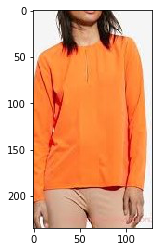

In [8]:
image = imageio.imread("./fashion/9.jpg")
plt.imshow(image)